-step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

-type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

-amount - amount of the transaction in local currency.

-nameOrig - customer who started the transaction

-oldbalanceOrg - initial balance before the transaction

-newbalanceOrig - new balance after the transaction

-nameDest - customer who is the recipient of the transaction

-oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

-newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

-isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

-isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

import pandas.util.testing as tm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  del sys.path[0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Because of resource limitation we are going to work with 600,000 data points
fraud= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud.csv',nrows=600000)

In [4]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            600000 non-null  int64  
 1   type            600000 non-null  object 
 2   amount          600000 non-null  float64
 3   nameOrig        600000 non-null  object 
 4   oldbalanceOrg   600000 non-null  float64
 5   newbalanceOrig  600000 non-null  float64
 6   nameDest        600000 non-null  object 
 7   oldbalanceDest  600000 non-null  float64
 8   newbalanceDest  600000 non-null  float64
 9   isFraud         600000 non-null  int64  
 10  isFlaggedFraud  600000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 50.4+ MB


In [6]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,600000.000000,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,600000.000000,600000.0
mean,15.579285,1.610948e+05,8.879161e+05,9.077204e+05,9.732537e+05,1.136523e+06,0.000602,0.0
std,5.482356,2.691603e+05,2.955238e+06,2.992303e+06,2.315887e+06,2.474046e+06,0.024522,0.0
min,1.000000,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,12.000000,1.231988e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,15.000000,7.550923e+04,1.776339e+04,0.000000e+00,1.127104e+05,2.057941e+05,0.000000,0.0
75%,19.000000,2.150715e+05,1.567722e+05,1.956683e+05,8.900036e+05,1.168897e+06,0.000000,0.0
max,34.000000,1.000000e+07,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07,1.000000,0.0


In [7]:
fraud.type.value_counts()

CASH_OUT    212756
PAYMENT     203602
CASH_IN     130073
TRANSFER     48949
DEBIT         4620
Name: type, dtype: int64

In [8]:
type_tr=dict(fraud.type.value_counts())
print(type_tr)

{'CASH_OUT': 212756, 'PAYMENT': 203602, 'CASH_IN': 130073, 'TRANSFER': 48949, 'DEBIT': 4620}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


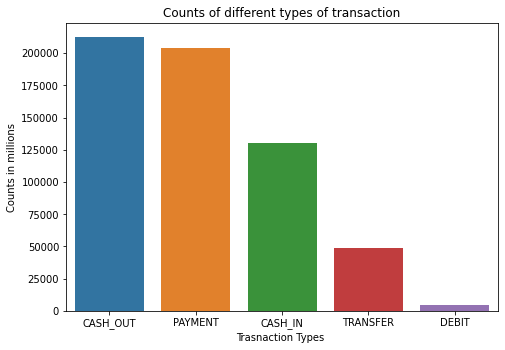

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ty = list(type_tr.keys())
count = list(type_tr.values())
sns.barplot(ty,count)
plt.title('Counts of different types of transaction')
plt.ylabel('Counts in millions')
plt.xlabel('Trasnaction Types ')
plt.show()

In [10]:
fraud_1=fraud[fraud['isFraud']==1]

In [11]:
fraud_1.type.value_counts()

CASH_OUT    186
TRANSFER    175
Name: type, dtype: int64

# So it is observe that Fraud case mostly happend in Cash_out and Transfer transaction

In [12]:
typ=dict(fraud_1.type.value_counts())
print(typ)

{'CASH_OUT': 186, 'TRANSFER': 175}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


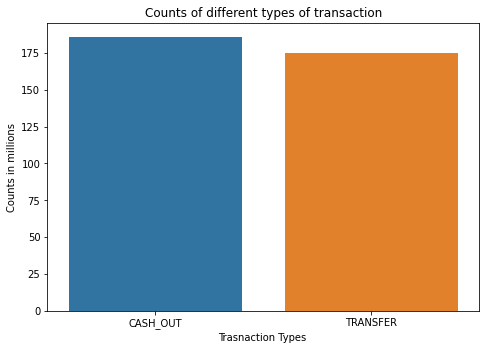

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ty = list(typ.keys())
#count = fraud_1.type.value_counts().values
count = list(typ.values())
sns.barplot(ty,count)
plt.title('Counts of different types of transaction')
plt.ylabel('Counts in millions')
plt.xlabel('Trasnaction Types ')
plt.show()

In [14]:
fraud_flag=fraud[fraud['isFlaggedFraud']==1]
fraud_flag.type.value_counts()

Series([], Name: type, dtype: int64)

### Predefine model only flagged the few Transaction from TRANSFER
### So we are going to remove all the rows which have CASH_IN, PAYMENT and DEBIT type in columns

In [16]:
data= fraud.loc[fraud['type'].isin(['CASH_OUT', 'TRANSFER'])]
data.shape

(261705, 11)

In [18]:
class_label= data['isFraud']
#print(class_label)

In [19]:
data= data.drop(['isFraud','isFlaggedFraud'],axis=1)

In [20]:
data.head()
df=data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89


In [21]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#df['nameOrig'].apply(LabelEncoder().fit_transform)
#h=OneHotEncoder().fit_transform(df)
encoder= LabelEncoder()
type_enc= encoder.fit_transform(data['type'])
nameO_enc= encoder.fit_transform(data['nameOrig'])
nameD_enc= encoder.fit_transform(data['nameDest'])

In [22]:
data['type']=type_enc
data['nameOrig']= nameO_enc
data['nameDest']= nameD_enc
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
2,1,1,181.00,40937,181.0,0.0,38931,0.0,0.00
3,1,0,181.00,240122,181.0,0.0,34661,21182.0,0.00
15,1,0,229133.94,248763,15325.0,0.0,36938,5083.0,51513.44
19,1,1,215310.30,90405,705.0,0.0,2708,22425.0,0.00
24,1,1,311685.89,132711,10835.0,0.0,48971,6267.0,2719172.89


In [23]:
X= data
#print(X)
y=class_label
#print(y)
X.shape

(261705, 9)

## Spliting data in train and test data set with a test size of 20% from data points

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(209364, 9)
(52341, 9)
(209364,)
(52341,)


In [26]:
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.sparse

## Normalizing data-points

In [27]:
normalizer= Normalizer()

normalizer.fit(X_train['step'].values.reshape(1,-1))
x_tr_step = scipy.sparse.csr_matrix(normalizer.transform(X_train['step'].values.reshape(-1,1)))
x_te_step = scipy.sparse.csr_matrix(normalizer.transform(X_test['step'].values.reshape(-1,1)))
#a= scipy.sparse.coo_matrix(x_tr_step)
print(x_tr_step.shape)
print(x_te_step.shape)
print('='*50)

normalizer.fit(X_train['type'].values.reshape(1,-1))
x_tr_type = scipy.sparse.csr_matrix(normalizer.transform(X_train['type'].values.reshape(-1,1)))
x_te_type = scipy.sparse.csr_matrix(normalizer.transform(X_test['type'].values.reshape(-1,1)))
#b=scipy.sparse.coo_matrix(x_tr_type)
print(x_tr_type.shape)
print(x_te_type.shape)
print("="*50)

normalizer.fit(X_train['amount'].values.reshape(1,-1))
x_tr_amount = scipy.sparse.csr_matrix(normalizer.transform(X_train['amount'].values.reshape(-1,1)))
x_te_amount = scipy.sparse.csr_matrix(normalizer.transform(X_test['amount'].values.reshape(-1,1)))
print(x_tr_amount.shape)
print(x_te_amount.shape)
print("="*50)

normalizer.fit(X_train['nameOrig'].values.reshape(1,-1))
x_tr_nameO = scipy.sparse.csr_matrix(normalizer.transform(X_train['nameOrig'].values.reshape(-1,1)))
x_te_nameO = scipy.sparse.csr_matrix(normalizer.transform(X_test['nameOrig'].values.reshape(-1,1)))
print(x_tr_nameO.shape)
print(x_te_nameO.shape)
print("="*50)

normalizer.fit(X_train['oldbalanceOrg'].values.reshape(1,-1))
x_tr_oldBalO = scipy.sparse.csr_matrix(normalizer.transform(X_train['oldbalanceOrg'].values.reshape(-1,1)))
x_te_oldBalO = scipy.sparse.csr_matrix(normalizer.transform(X_test['oldbalanceOrg'].values.reshape(-1,1)))
print(x_tr_oldBalO.shape)
print(x_te_oldBalO.shape)
print("="*50)

normalizer.fit(X_train['newbalanceOrig'].values.reshape(1,-1))
x_tr_newBalO = scipy.sparse.csr_matrix(normalizer.transform(X_train['newbalanceOrig'].values.reshape(-1,1)))
x_te_newBalO = scipy.sparse.csr_matrix(normalizer.transform(X_test['newbalanceOrig'].values.reshape(-1,1)))
print(x_tr_newBalO.shape)
print(x_te_newBalO.shape)
print("="*50)

normalizer.fit(X_train['nameDest'].values.reshape(1,-1))
x_tr_nameD = scipy.sparse.csr_matrix(normalizer.transform(X_train['nameDest'].values.reshape(-1,1)))
x_te_nameD = scipy.sparse.csr_matrix(normalizer.transform(X_test['nameDest'].values.reshape(-1,1)))
print(x_tr_nameD.shape)
print(x_te_nameD.shape)
print("="*50)

normalizer.fit(X_train['oldbalanceDest'].values.reshape(1,-1))
x_tr_oldBalD = scipy.sparse.csr_matrix(normalizer.transform(X_train['oldbalanceDest'].values.reshape(-1,1)))
x_te_oldBalD = scipy.sparse.csr_matrix(normalizer.transform(X_test['oldbalanceDest'].values.reshape(-1,1)))
print(x_tr_oldBalD.shape)
print(x_te_oldBalD.shape)
print("="*50)

normalizer.fit(X_train['newbalanceDest'].values.reshape(1,-1))
x_tr_newBalD = scipy.sparse.csr_matrix(normalizer.transform(X_train['newbalanceDest'].values.reshape(-1,1)))
x_te_newBalD = scipy.sparse.csr_matrix(normalizer.transform(X_test['newbalanceDest'].values.reshape(-1,1)))
print(x_tr_newBalD.shape)
print(x_te_newBalD.shape)
print("="*50)

(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)
(209364, 1)
(52341, 1)


In [29]:
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

x_train= hstack((x_tr_step,x_tr_type,x_tr_amount,x_tr_nameO,x_tr_oldBalO,x_tr_newBalO,x_tr_nameD,x_tr_oldBalD,x_tr_newBalD)).tocsr()
#x_train= hstack((csr_matrix(x_tr_step),csr_matrix(x_tr_type))).tocsr()
print(x_train.shape)
x_test= hstack((x_te_step,x_te_type,x_te_amount,x_te_nameO,x_te_oldBalO,x_te_newBalO,x_te_nameD,x_te_oldBalD,x_te_newBalD)).tocsr()
print(x_test.shape)

(209364, 9)
(52341, 9)


# Model-1 Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'C': [0.01,0.1,1,10,20]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=3)
model.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 20]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [31]:
print(model.best_estimator_)
best_p=model.best_params_
print('Best Hyper-parameter:',model.best_params_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Hyper-parameter: {'C': 0.01}


In [32]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [33]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Hyperparameter tuning for Logistic Regression

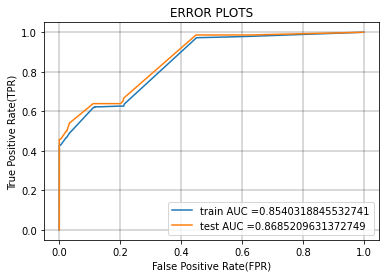

In [34]:
tuned_parameters = [{'C': [0.01]}]
model_best = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=3)
model_best.fit(x_train, y_train)


y_train_predlr = batch_predict(model_best, x_train)    
y_test_predlr = batch_predict(model_best, x_test)

train_fprlr, train_tprlr, tr_thresholdslr = roc_curve(y_train, y_train_predlr)
test_fprlr, test_tprlr, te_thresholdslr = roc_curve(y_test, y_test_predlr)

plt.plot(train_fprlr, train_tprlr, label="train AUC ="+str(auc(train_fprlr, train_tprlr)))
plt.plot(test_fprlr, test_tprlr, label="test AUC ="+str(auc(test_fprlr, test_tprlr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

In [35]:
test_auc_lr= auc(test_fprlr, test_tprlr)
print(test_auc_lr)

0.8685209631372749


## Confusion Matrix for Logistic Regression

### Train Confusion Matrix

the maximum value of tpr*(1-fpr) 0.5503490204629305 for threshold 0.003
Train confusion matrix
[[184742  24333]
 [   109    180]]
Test confusion matrix
[[46280  5989]
 [   26    46]]


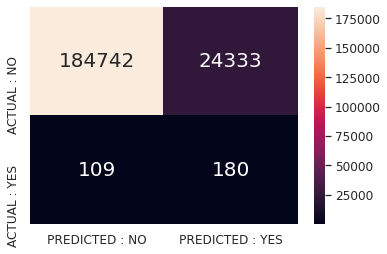

In [36]:
from sklearn.metrics import confusion_matrix
best_lr = find_best_threshold(tr_thresholdslr, train_fprlr, train_tprlr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_predlr, best_lr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_predlr, best_lr)))
conf_train=(confusion_matrix(y_train, predict_with_best_t(y_train_predlr, best_lr)))
conf_test=(confusion_matrix(y_test, predict_with_best_t(y_test_predlr, best_lr)))

sns.set(font_scale=1.1)#for label size
sns.heatmap(conf_train, annot=True,annot_kws={"size": 20}, fmt='',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])

### Test Confusion Matrix

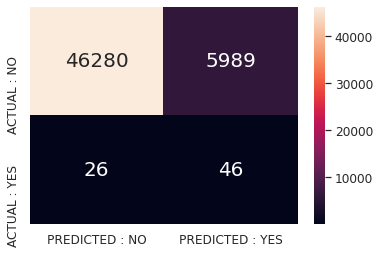

In [37]:
sns.heatmap(conf_test, annot=True,annot_kws={"size": 20}, fmt='g',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])

# Model-2 Light GBM

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, auc

parameters = {'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3] , 'n_estimators': [10, 50, 75, 100, 200]}
lgb_train=lgb.Dataset(x_train,label=y_train)
lgbm_test=lgb.Dataset(x_test,label=y_test,reference=lgb_train)
model1=lgb.LGBMClassifier()

lgbm = GridSearchCV(model1,param_grid=parameters, cv=3, scoring='roc_auc',n_jobs=10,return_train_score=True)
lgb_clf= lgbm.fit(x_train,y_train)

In [39]:
print(lgb_clf.best_estimator_)
print(lgb_clf.score(x_train,y_train))
print(lgb_clf.score(x_test,y_test))
print(lgb_clf.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
0.8944907602981828
0.8983037268744379
{'learning_rate': 0.001, 'n_estimators': 200}


In [40]:
train_score=lgb_clf.cv_results_['mean_train_score']
test_score= lgb_clf.cv_results_['mean_test_score']
best_lr= lgb_clf.best_params_['learning_rate']
best_est= lgb_clf.best_params_['n_estimators']
best_score= lgb_clf.best_score_
best_lp= lgb_clf.best_params_
print("train score:",train_score)
print("test score:",test_score)
print("Best Learning Rate:", best_lr)
print("Best n_estimators:",best_est)
print("Best Score:",best_score)

train score: [0.89624408 0.89624408 0.89624408 0.89624559 0.89624842 0.89619414
 0.89622793 0.89622409 0.89622398 0.89622973 0.57790069 0.51160132
 0.51160808 0.5116032  0.5116063  0.45763009 0.55035358 0.55035358
 0.55035358 0.55035358 0.47248572 0.49633108 0.49633108 0.49633108
 0.49633108]
test score: [0.88502171 0.88502117 0.88502117 0.88501673 0.88502651 0.88492738
 0.88497484 0.88479628 0.88479628 0.88469072 0.55807253 0.49697323
 0.49686761 0.496799   0.49679407 0.45313454 0.51023688 0.51023688
 0.51023688 0.51023688 0.48745994 0.5095109  0.5095109  0.5095109
 0.5095109 ]
Best Learning Rate: 0.001
Best n_estimators: 200
Best Score: 0.8850265107917424


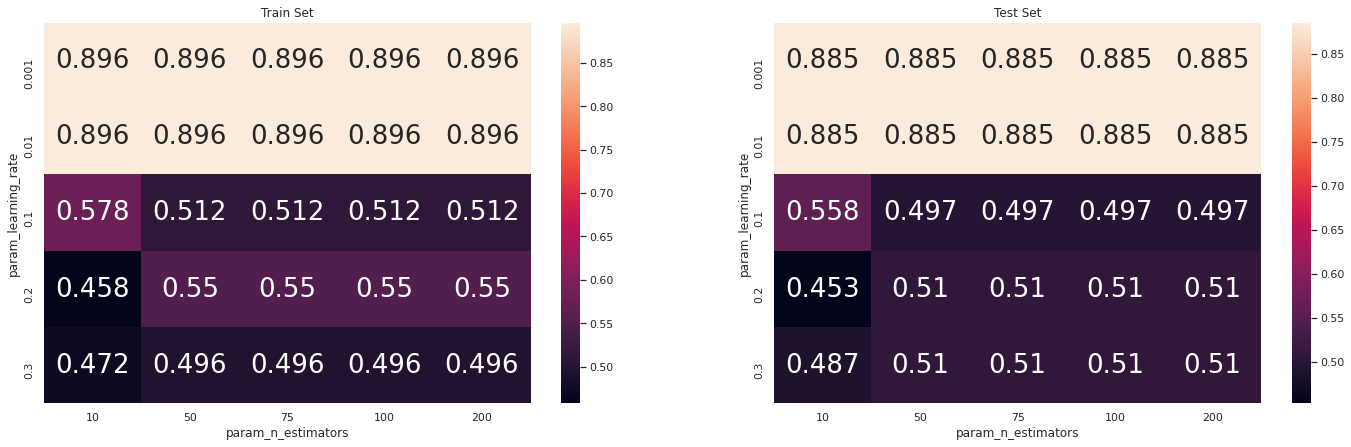

In [41]:
sns.set(font_scale=1)
max_scores1 = pd.DataFrame(lgb_clf.cv_results_).groupby(['param_learning_rate','param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,7))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.3g',ax= ax1,annot_kws={"size": 26})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.3g',ax= ax2,annot_kws={"size": 26})
ax1.set_title('Train Set')
ax2.set_title('Test Set')
plt.show()

## Hyper-parameter tuning for Light GBM

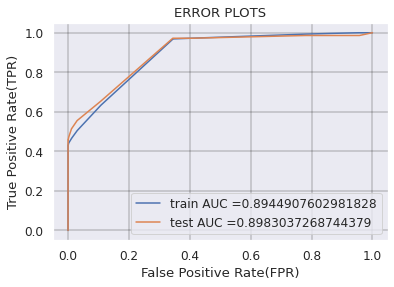

In [57]:
parameters = {'learning_rate':[0.001], 'n_estimators': [200]}
#best_model = xgb.XGBClassifier(max_depth= best_depth, n_estimators=best_est,eval_metric='mlogloss')
best_model = lgb.LGBMClassifier(n_estimators =best_est,learning_rate =best_lr)
lgb_best = GridSearchCV(best_model, parameters, cv=5, scoring='roc_auc')
lgb_best.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(lgb_best, x_train)    
y_test_pred = batch_predict(lgb_best, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

In [59]:
test_auc_lgb= auc(test_fpr, test_tpr)
print(test_auc_lgb)

0.8983037268744379


## Confusin Matrix for Light GBM

### Train Confusion Matrix

the maximum value of tpr*(1-fpr) 0.6344671102363475 for threshold 0.001
Train confusion matrix
[[136915  72160]
 [     9    280]]
Test confusion matrix
[[34276 17993]
 [    2    70]]


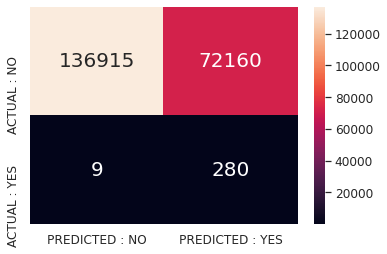

In [60]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
conf_train=(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
conf_test=(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

sns.set(font_scale=1.1)#for label size
sns.heatmap(conf_train, annot=True,annot_kws={"size": 20}, fmt='',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])

### Test Confusion Matrix

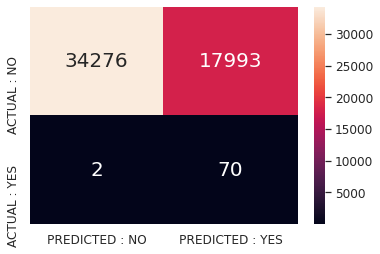

In [61]:
sns.heatmap(conf_test, annot=True,annot_kws={"size": 20}, fmt='g',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])

# Random Forest Classifier for Feature Selection

In [56]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)

rf_random.fit(x_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [47]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [48]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=51, min_samples_split=125,
            min_weight_fraction_leaf=0.0, n_estimators=117, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [49]:
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

In [50]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.5330396475770924
Test f1 score 0.5945945945945945


In [51]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Confusion-matrix, Precision-matrix, Recall-matrix of Random Forest Classifier

Train confusion_matrix


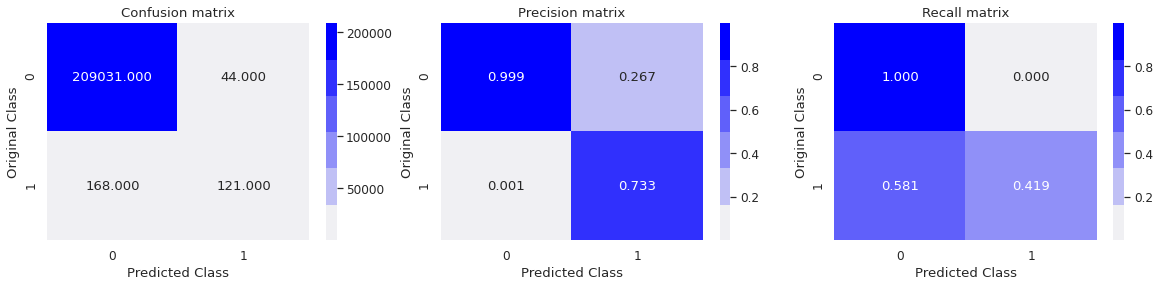

Test confusion_matrix


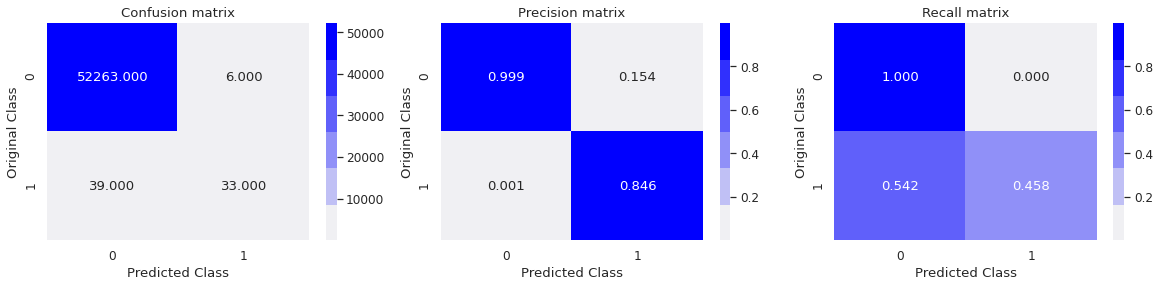

In [52]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

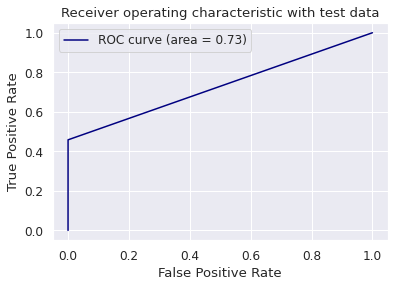

In [53]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## Feature Importance

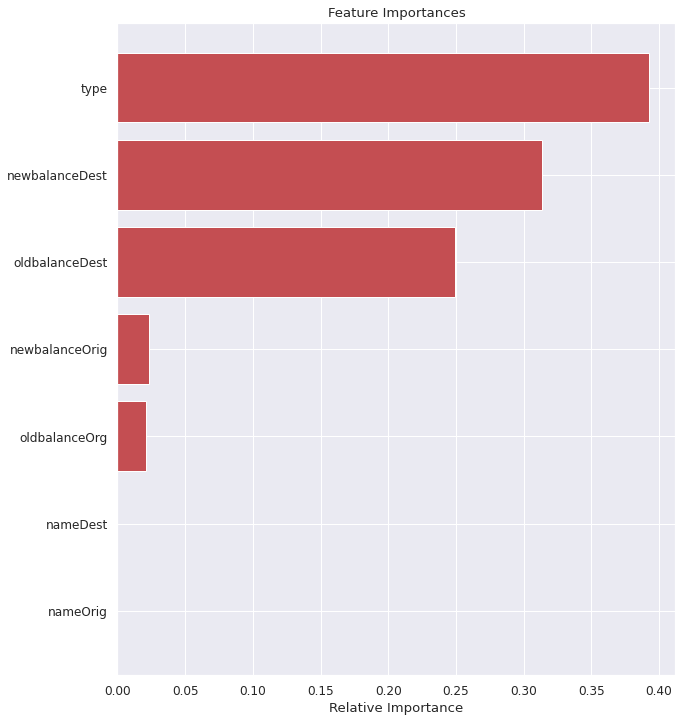

In [54]:
features = data.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-7:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Observation and Conclusion

In [62]:
from prettytable import PrettyTable
p= PrettyTable()
p.field_names=['Model','Hyper-parameter','AUC']
p.add_row(['Logistic-Regression',best_p,test_auc_lr])
p.add_row(['LightGBM',best_lp,test_auc_lgb])
print(p)

+---------------------+-----------------------------------------------+--------------------+
|        Model        |                Hyper-parameter                |        AUC         |
+---------------------+-----------------------------------------------+--------------------+
| Logistic-Regression |                  {'C': 0.01}                  | 0.8685209631372749 |
|       LightGBM      | {'learning_rate': 0.001, 'n_estimators': 200} | 0.8983037268744379 |
+---------------------+-----------------------------------------------+--------------------+


### -As it is been observe that AUC score for Logistic Regression is 0.868, where as AUC score for Light GBM is 0.898.
### -There is not much difference in AUC score between them.
### - But if we observe Confusion matrix of both Model then:

### 1) Logistic Regression:
#### (a) Train- TP = 180 and FN = 109
#### (b) Test- TP = 46 and FN = 26

### 2) Light GBM:
#### (a) Train- TP = 280 and FN = 9
#### (b) Test- TP = 70 and FN = 2

### Though both model have very similar AUC score but the mistake factors of Light GBM model is way lesser than the Logistic Regression model. 